## **Project - June 2024**
**Financial_Risk_Analysis_and_model_building**
=====================================
## **Multi_regression** 
----------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"E:\data\p2p_regression.csv")
df.shape

(113937, 65)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 65 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           113937 non-null  int64  
 1   ListingCreationDate                  113937 non-null  object 
 2   CreditGrade                          113937 non-null  object 
 3   Term                                 113937 non-null  int64  
 4   LoanStatus                           113937 non-null  object 
 5   ClosedDate                           113937 non-null  object 
 6   BorrowerAPR                          113937 non-null  float64
 7   BorrowerRate                         113937 non-null  float64
 8   LenderYield                          113937 non-null  float64
 9   EstimatedEffectiveYield              113937 non-null  float64
 10  EstimatedLoss                        113937 non-null  float64
 11  EstimatedRetu

In [4]:
df.isnull().sum().sum()

0

In [5]:
df.duplicated().sum()

0

**Model Formulas**

# Loan Tenure:

In [6]:
df["Term"].describe()

count    113937.000000
mean         40.830248
std          10.436212
min          12.000000
25%          36.000000
50%          36.000000
75%          36.000000
max          60.000000
Name: Term, dtype: float64

In [7]:
date_cols = ["ClosedDate", "LoanOriginationDate", "ListingCreationDate"]

df.dropna()

df.shape

(113937, 65)

In [8]:
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df.shape

(113937, 65)

In [9]:
print(df.shape)
df[date_cols].head()

(113937, 65)


,ClosedDate,LoanOriginationDate,ListingCreationDate
0,2009-08-14,2007-09-12,2007-08-26 19:09:29.263
1,2014-03-04,2014-03-03,2014-02-27 08:28:07.900
2,2009-12-17,2007-01-17,2007-01-05 15:00:47.090
3,2014-03-04,2012-11-01,2012-10-22 11:02:35.010
4,2014-03-04,2013-09-20,2013-09-14 18:38:39.097


**LoanTenure = (𝑀𝑎𝑡𝑢𝑟𝑖𝑡𝑦𝐷𝑎𝑡_𝑂𝑟𝑖𝑔𝑖𝑛𝑎𝑙𝑦𝑒𝑎𝑟 − 𝐿𝑜𝑎𝑛𝐷𝑎𝑡𝑒𝑦𝑒𝑎𝑟) 𝑥 12 −
(𝑀𝑎𝑡𝑢𝑟𝑖𝑡𝑦𝐷𝑎𝑡𝑒_𝑂𝑟𝑖𝑔𝑖𝑛𝑎𝑙𝑚𝑜𝑛𝑡ℎ − 𝐿𝑜𝑎𝑛𝐷𝑎𝑡𝑒𝑚𝑜𝑛𝑡ℎ)**

In [10]:
df["LoanTenure"] = ((df["ClosedDate"].dt.year - df["LoanOriginationDate"].dt.year) * 12) - (df["ClosedDate"].dt.month - df["LoanOriginationDate"].dt.month)

In [11]:
print(df["LoanTenure"].shape)
df.shape

(113937,)


(113937, 66)

In [12]:
df["LoanTenure"].describe()

count    113917.000000
mean         18.276798
std          13.172031
min         -27.000000
25%          11.000000
50%          18.000000
75%          28.000000
max          59.000000
Name: LoanTenure, dtype: float64

In [13]:
print(df["Term"].describe())
print(df["LoanTenure"].describe())

count    113937.000000
mean         40.830248
std          10.436212
min          12.000000
25%          36.000000
50%          36.000000
75%          36.000000
max          60.000000
Name: Term, dtype: float64
count    113917.000000
mean         18.276798
std          13.172031
min         -27.000000
25%          11.000000
50%          18.000000
75%          28.000000
max          59.000000
Name: LoanTenure, dtype: float64


In [14]:
df.drop(date_cols, axis=1, inplace=True)
df.drop("LoanTenure", axis=1, inplace=True)
df.rename(columns={"Term" : "LoanTenure"}, inplace=True)

In [15]:
df.shape

(113937, 62)

# Equated Monthly Installments (EMI):

-	Tenure ---> **LoanTenure**
-	Principle repayment ---> **LP_CustomerPrinciplePayments**
-	Interest ---> **BorrowerRate**


In [16]:
emi_cols = ["LP_CustomerPayments", "LP_CustomerPrincipalPayments"]
df[emi_cols].head()

,LP_CustomerPayments,LP_CustomerPrincipalPayments
0,11396.14,9425.00
1,0.00,0.00
2,4186.63,3001.00
3,5143.20,4091.09
4,2819.85,1563.22


**For each row in the dataset:**
1. Calculate result_1 = P * r * 〖(1+r)〗^n
2. Calculate result_2 = 〖(1+r)〗^n – 1
3. Calculate EMI = result_1 / result_2


In [17]:
def cal_EMI(P, r, n):
  P = P.values
  r = r.values
  n = n.values
  #print(P.shape[0])
  result_1 = np.empty(0)
  result_2 = np.empty(0)
  result = np.empty(0)
  for i in range(P.shape[0]):
    #print(P[i])
    #print(r[i])
    #print(n[i])
    # EMI = P × r × (1 + r) ^ n / ((1 + r) ^ n – 1)
    #print(P[i] * (1 + r[i]))
    result_1 = np.append(result_1, P[i] * r[i] * np.power((1 + r[i]),n[i]))
    result_2 = np.append(result_2, np.power((1 + r[i]),n[i]) - 1)
    result = np.append(result, (result_1[i] / result_2[i]))

  return result

In [18]:
df["BorrowerRate"].describe()

count    113937.000000
mean          0.192764
std           0.074818
min           0.000000
25%           0.134000
50%           0.184000
75%           0.250000
max           0.497500
Name: BorrowerRate, dtype: float64

In [19]:
df["EMI"] = cal_EMI(df["LP_CustomerPrincipalPayments"], df["BorrowerRate"], df["LoanTenure"])

df["EMI"].describe()

count    113929.000000
mean        558.230883
std         720.251611
min           0.000000
25%          90.728391
50%         287.662239
75%         739.577224
max        8780.054436
Name: EMI, dtype: float64

# Eligible Loan Amount (ELA):

**Components of ELA:**
-	A: “AppliedAmount” ---> **LoanOriginalAmount**
-	R: “Interest” ---> **BorrowerRate**
-	N: “LoanTenure” ---> **LoanTenure**
-	I: “IncomeTotal”  ---> **StatedMonthlyIncome**

In [20]:
ela_cols = ['DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome']

df[ela_cols].head()

,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome
0,0.17,"$25,000-49,999",True,3083.333333
1,0.18,"$50,000-74,999",True,6125.000000
2,0.06,Not displayed,True,2083.333333
3,0.15,"$25,000-49,999",True,2875.000000
4,0.26,"$100,000+",True,9583.333333


In [21]:
df_new = df[df['IncomeVerifiable'] == True]

print(df_new.shape)
print(df.shape[0] - df_new.shape[0])

(105268, 63)
8669


**Calculation Procedure:**
**For each row in the dataset:**
1.	Calculate: Total Payment Due = (A + (A*r)) * n
2.	Calculate: Max allowable amount = I * 12 * 30%
3.	If ( Total Payment Due <= Max allowable amount)
            Then ELA = AppliedAmount
            Else ELA = Max allowable amount


In [22]:
def eligible_loan_amnt(df):
  df['Ava_Inc'] = (df['StatedMonthlyIncome'] * 12 * 0.3) * df['LoanTenure']
  df['Total_Loan_Amnt'] = np.round(df['LoanOriginalAmount'] + (df['LoanOriginalAmount'] * df['BorrowerRate']) *df['LoanTenure'])

  ELA = np.empty(0)

  for i in range(len(df['Ava_Inc'].values)):
    if df['Ava_Inc'].iloc[i] <= 0:
      ELA = np.append(ELA, 0)
    elif df['Total_Loan_Amnt'].iloc[i] <= df['Ava_Inc'].iloc[i]:
      ELA = np.append(ELA, df['Total_Loan_Amnt'].iloc[i])
    else:
      ELA = np.append(ELA, df['Ava_Inc'].iloc[i])

  df.drop(["Ava_Inc", "Total_Loan_Amnt"], axis=1, inplace=True)

  return ELA

In [23]:
df['ELA'] = eligible_loan_amnt(df)

df['ELA'].describe()

count    113937.000000
mean      70997.027956
std       60375.953468
min           0.000000
25%       28057.000000
50%       49749.000000
75%       96184.000000
max      416990.000000
Name: ELA, dtype: float64

In [24]:
# Dropping extra cols
['CreditGrade', 'ClosedDate',
       'ProsperRating (Alpha)', 'ListingCategory', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner',
       'CurrentlyInGroup', 'GroupKey', 'FirstRecordedCreditLine',
       'IncomeRange', 'IncomeVerifiable', 'LoanOriginationDate']
df.drop(['LoanStatus'], axis=1, inplace=True)

In [25]:
df.shape

(113937, 63)

# Preferred Return on Investment (PROI):

In [26]:
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

## Simple Data Preprocessing

In [27]:
df.select_dtypes(exclude=[int, float]).columns

Index(['CreditGrade', 'ProsperRating (Alpha)', 'BorrowerState', 'Occupation',
       'EmploymentStatus', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'GroupKey', 'FirstRecordedCreditLine', 'IncomeRange',
       'IncomeVerifiable', 'status', 'CreditScoreRange'],
      dtype='object')

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

cat_cols

Index(['CreditGrade', 'ProsperRating (Alpha)', 'BorrowerState', 'Occupation',
       'EmploymentStatus', 'GroupKey', 'FirstRecordedCreditLine',
       'IncomeRange', 'status', 'CreditScoreRange'],
      dtype='object')

In [29]:
bool_cols = ['IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable']

for col in bool_cols:
    df[col] = df[col].astype(int)

In [30]:
df.isnull().sum().sum()

8

In [31]:
df.dropna(inplace=True)

In [32]:
df.isnull().sum().sum()

0

In [33]:
## Feature Importance Analysis

In [34]:
x = df.drop(["status"], axis=1)

y = df["status"]

print(df.shape)
print(y.shape)

(113929, 63)
(113929,)


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_scale = scaler.fit_transform(x)

In [36]:
from sklearn.model_selection import train_test_split

#Train Test for Classification
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [37]:
from sklearn.ensemble import RandomForestRegressor

rid_reg = RandomForestRegressor()

rid_reg.fit(x_train, y_train)

y_pred_base = rid_reg.predict(x_test)

In [38]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# model evaluation
print('Ridge Regression - Base Model:')
print('mean_squared_error : ', mean_squared_error(y_test, y_pred_base))
print('mean_squared_percentage_error : ', mean_absolute_percentage_error(y_test, y_pred_base))
print('R2_score : ', r2_score(y_test, y_pred_base))

Ridge Regression - Base Model:
mean_squared_error :  0.12765279991573922
mean_squared_percentage_error :  306743786718.39594
R2_score :  0.8798511729887405


In [39]:
result = pd.DataFrame(x.columns.values, columns=['feature_name'])
result['importance'] = rid_reg.feature_importances_
result.sort_values(by='importance', ascending=False, inplace=True)
result.head(10)

,feature_name,importance
49,LoanCurrentDaysDelinquent,0.580869
53,LP_CustomerPrincipalPayments,0.108445
8,EstimatedReturn,0.062438
50,LoanOriginalAmount,0.060605
12,ListingCategory (numeric),0.038084
15,EmploymentStatus,0.015536
60,EMI,0.008170
61,ELA,0.008067
6,EstimatedEffectiveYield,0.008047
52,LP_CustomerPayments,0.007400


In [40]:
important_cols = result.head(20)['feature_name'].tolist()

## Analysis of Numerical Attributes

In [41]:
# WoE function for ordered discrete and continuous variables
def woe_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [42]:
important_cols = important_cols[:5]
important_cols

['LoanCurrentDaysDelinquent',
 'LP_CustomerPrincipalPayments',
 'EstimatedReturn',
 'LoanOriginalAmount',
 'ListingCategory (numeric)']

In [43]:
target = df["status"]
df_new = df[important_cols]
df_new.shape

(113929, 5)

In [44]:
df_new.select_dtypes(include=[int, float]).columns

Index(['LoanCurrentDaysDelinquent', 'LP_CustomerPrincipalPayments',
       'EstimatedReturn', 'LoanOriginalAmount', 'ListingCategory (numeric)'],
      dtype='object')

#### **LP_CustomerPrincipalPayments**

In [45]:
pd.options.display.max_rows = None

df_new['LP_CustomerPrincipalPayments_factor'] = pd.cut(df_new['LP_CustomerPrincipalPayments'], 50)

temp = woe_continuous(df_new, 'LP_CustomerPrincipalPayments_factor', target)

temp

,LP_CustomerPrincipalPayments_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-35.0, 700.0]",35027,2.872670,0.307446,100621.0,-65594.0,0.341580,0.363108,-0.061118,NaN,NaN,0.004539
1,"(700.0, 1400.0]",18025,2.722441,0.158213,49072.0,-31047.0,0.166586,0.171867,-0.031208,0.150229,0.029910,0.004539
2,"(1400.0, 2100.0]",13107,2.590143,0.115045,33949.0,-20842.0,0.115247,0.115375,-0.001105,0.132298,0.030103,0.004539
3,"(2100.0, 2800.0]",7507,2.575729,0.065892,19336.0,-11829.0,0.065640,0.065482,0.002420,0.014413,0.003525,0.004539
4,"(2800.0, 3500.0]",7706,2.381261,0.067639,18350.0,-10644.0,0.062293,0.058922,0.055639,0.194468,0.053219,0.004539
5,"(3500.0, 4200.0]",6190,2.348788,0.054332,14539.0,-8349.0,0.049356,0.046217,0.065699,0.032473,0.010060,0.004539
6,"(4200.0, 4900.0]",2543,2.511600,0.022321,6387.0,-3844.0,0.021682,0.021279,0.018757,0.162812,0.046942,0.004539
7,"(4900.0, 5600.0]",5017,2.209488,0.044036,11085.0,-6068.0,0.037630,0.033591,0.113569,0.302113,0.094813,0.004539
8,"(5600.0, 6300.0]",2493,2.320899,0.021882,5786.0,-3293.0,0.019642,0.018229,0.074648,0.111411,0.038922,0.004539
9,"(6300.0, 7000.0]",2238,2.315013,0.019644,5181.0,-2943.0,0.017588,0.016292,0.076574,0.005885,0.001926,0.004539


In [46]:
pd.options.display.max_rows = None

temp = df_new[df_new['LP_CustomerPrincipalPayments'] < 2000]
temp['LP_CustomerPrincipalPayments_factor'] = pd.cut(temp['LP_CustomerPrincipalPayments'], 30)

temp = woe_continuous(temp, 'LP_CustomerPrincipalPayments_factor', target)

temp

,LP_CustomerPrincipalPayments_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2.0, 66.666]",7473,2.915697,0.118821,21789.0,-14316.0,0.123544,0.126162,-0.020969,NaN,NaN,0.000907
1,"(66.666, 133.333]",3073,2.855190,0.048861,8774.0,-5701.0,0.049749,0.050241,-0.009845,0.060506,0.011124,0.000907
2,"(133.333, 199.999]",3703,2.870105,0.058878,10628.0,-6925.0,0.060261,0.061028,-0.012642,0.014915,0.002797,0.000907
3,"(199.999, 266.665]",3561,2.858186,0.056620,10178.0,-6617.0,0.057710,0.058313,-0.010410,0.011919,0.002232,0.000907
4,"(266.665, 333.332]",3482,2.887134,0.055364,10053.0,-6571.0,0.057001,0.057908,-0.015791,0.028948,0.005381,0.000907
5,"(333.332, 399.998]",3086,2.869410,0.049067,8855.0,-5769.0,0.050208,0.050840,-0.012513,0.017724,0.003278,0.000907
6,"(399.998, 466.664]",2783,2.831117,0.044250,7879.0,-5096.0,0.044674,0.044909,-0.005251,0.038293,0.007262,0.000907
7,"(466.664, 533.331]",2456,2.893730,0.039050,7107.0,-4651.0,0.040297,0.040988,-0.016998,0.062612,0.011747,0.000907
8,"(533.331, 599.997]",2106,2.819088,0.033485,5937.0,-3831.0,0.033663,0.033761,-0.002918,0.074641,0.014080,0.000907
9,"(599.997, 666.663]",2220,2.848198,0.035298,6323.0,-4103.0,0.035852,0.036158,-0.008521,0.029110,0.005603,0.000907


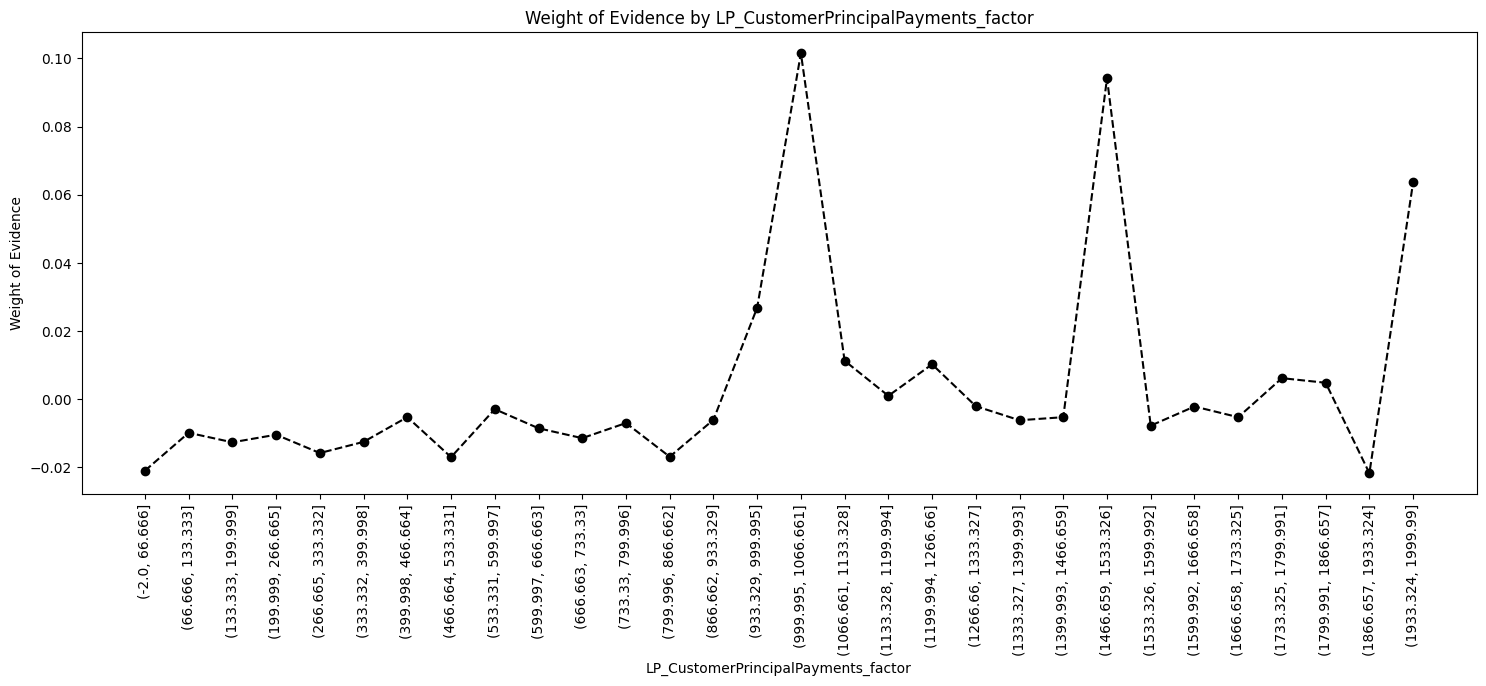

In [47]:
plot_by_woe(temp, 90)

* More than 10500
* Between 2000 and 10500
* Between 1000 and 2000
* Less than 200

In [48]:
# Create categorie
df_new['LP_CustomerPrincipalPayments_factor'] = np.where(df_new['LP_CustomerPrincipalPayments'] < 200, "<200",
                                                    np.where(df_new['LP_CustomerPrincipalPayments'] < 1000, "200_1k",
                                                    np.where(df_new['LP_CustomerPrincipalPayments'] < 2000, "1k_2k",
                                                    np.where(df_new['LP_CustomerPrincipalPayments'] < 10500, "2k_10.5k", ">10.5k"))))
df_new['LP_CustomerPrincipalPayments_factor'].value_counts()

LP_CustomerPrincipalPayments_factor
2k_10.5k    44584
200_1k      29013
1k_2k       19631
<200        14249
>10.5k       6452
Name: count, dtype: int64

#### **ProsperRating (Alpha)**

In [49]:
print(df.columns.tolist())

['Unnamed: 0', 'CreditGrade', 'LoanTenure', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey', 'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperP

In [50]:
df_new['ProsperRating_factor'] = df['ProsperRating (Alpha)'].apply(str)

# Print the data type of the new column
print(df_new['ProsperRating_factor'].dtype)

# Get value counts for the new column (optional)
value_counts = df_new['ProsperRating_factor'].value_counts()
print(value_counts)

object
ProsperRating_factor
3    47421
2    15581
0    14551
4    14274
5     9795
6     6935
1     5372
Name: count, dtype: int64


#### **LoanOriginalAmount**

In [51]:
df_new['LoanOriginalAmount_factor'] = pd.cut(df_new['LoanOriginalAmount'], 50)

temp = woe_continuous(df_new, 'LoanOriginalAmount_factor', target)

temp

,LoanOriginalAmount_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(966.0, 1680.0]",5975,2.016736,0.052445,12050.0,-6075.0,0.040906,0.033629,0.195888,NaN,NaN,0.003811
1,"(1680.0, 2360.0]",7167,2.373378,0.062908,17010.0,-9843.0,0.057744,0.054488,0.058047,0.356642,1.378418e-01,0.003811
2,"(2360.0, 3040.0]",10767,2.339556,0.094506,25190.0,-14423.0,0.085513,0.079841,0.068629,0.033822,1.058207e-02,0.003811
3,"(3040.0, 3720.0]",3744,2.351763,0.032863,8805.0,-5061.0,0.029891,0.028016,0.064761,0.012207,3.867286e-03,0.003811
4,"(3720.0, 4400.0]",15156,2.734824,0.133030,41449.0,-26293.0,0.140708,0.145550,-0.033833,0.383062,9.859464e-02,0.003811
5,"(4400.0, 5080.0]",9048,2.378205,0.079418,21518.0,-12470.0,0.073048,0.069030,0.056570,0.356619,9.040302e-02,0.003811
6,"(5080.0, 5760.0]",1429,2.427572,0.012543,3469.0,-2040.0,0.011776,0.011293,0.041922,0.049367,1.464747e-02,0.003811
7,"(5760.0, 6440.0]",3593,2.443919,0.031537,8781.0,-5188.0,0.029809,0.028719,0.037248,0.016347,4.674530e-03,0.003811
8,"(6440.0, 7120.0]",4599,2.541639,0.040367,11689.0,-7090.0,0.039681,0.039248,0.010969,0.097721,2.627914e-02,0.003811
9,"(7120.0, 7800.0]",3455,2.337482,0.030326,8076.0,-4621.0,0.027416,0.025580,0.069291,0.204158,5.832268e-02,0.003811


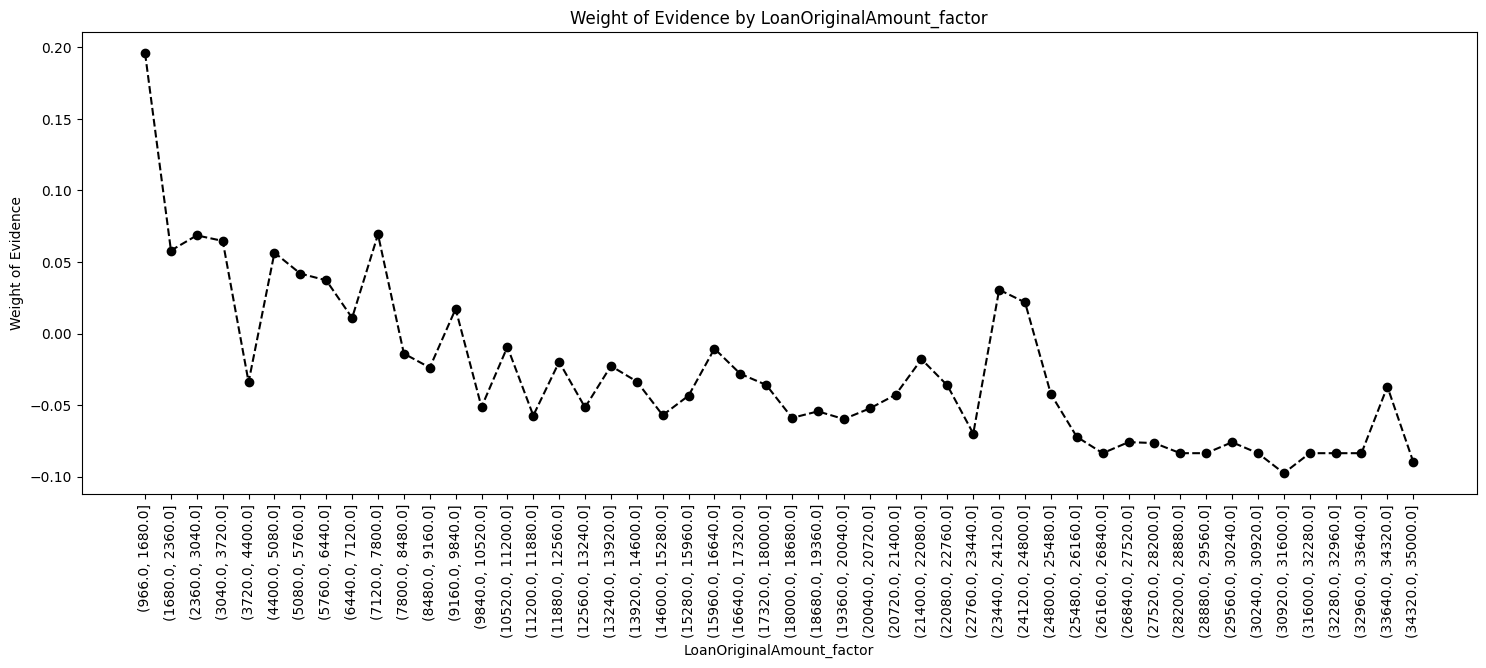

In [52]:
plot_by_woe(temp, 90)

In [53]:
temp = df_new[df_new['LoanOriginalAmount'] <= 9500]

temp['LoanOriginalAmount_factor'] = pd.cut(temp['LoanOriginalAmount'], 50)

temp = woe_continuous(temp, 'LoanOriginalAmount_factor', target)

temp

,LoanOriginalAmount_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(991.5, 1170.0]",3444,2.013066,0.048206,6933.0,-3489.0,0.039542,0.033584,0.163317,NaN,NaN,0.003888
1,"(1170.0, 1340.0]",642,2.052960,0.008986,1318.0,-676.0,0.007517,0.006507,0.144318,0.039893,0.019000,0.003888
2,"(1340.0, 1510.0]",1664,2.005409,0.023291,3337.0,-1673.0,0.019032,0.016104,0.167094,0.047551,0.022776,0.003888
3,"(1510.0, 1680.0]",225,2.053333,0.003149,462.0,-237.0,0.002635,0.002281,0.144145,0.047925,0.022949,0.003888
4,"(1680.0, 1850.0]",394,2.035533,0.005515,802.0,-408.0,0.004574,0.003927,0.152481,0.017800,0.008337,0.003888
5,"(1850.0, 2020.0]",6171,2.411441,0.086375,14881.0,-8710.0,0.084872,0.083839,0.012253,0.375908,0.140228,0.003888
6,"(2020.0, 2190.0]",199,2.140704,0.002785,426.0,-227.0,0.002430,0.002185,0.106129,0.270737,0.093876,0.003888
7,"(2190.0, 2360.0]",403,2.235732,0.005641,901.0,-498.0,0.005139,0.004794,0.069545,0.095028,0.036584,0.003888
8,"(2360.0, 2530.0]",3172,2.312736,0.044398,7336.0,-4164.0,0.041840,0.040081,0.042958,0.077004,0.026588,0.003888
9,"(2530.0, 2700.0]",922,2.193059,0.012905,2022.0,-1100.0,0.011532,0.010588,0.085417,0.119678,0.042459,0.003888


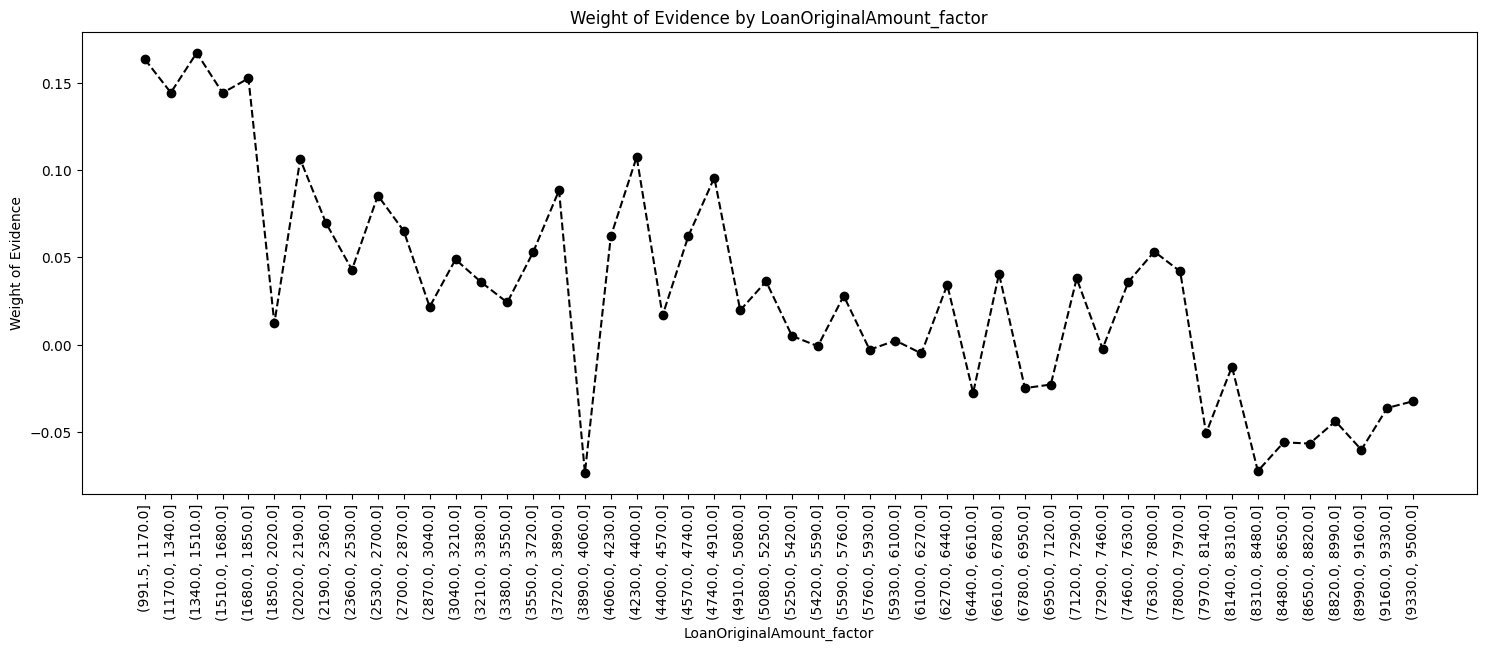

In [54]:
plot_by_woe(temp, 90)

* < 2000
* 2000 < x < 3000
* 3000 < x < 3500
* 3500 < x < 4000
* 4000 < x < 5000
* 5000 < x < 7500
* 7500 < x < 9500
* 9500 < x < 14500
* 14500 < x < 19500
* 19500 < x < 25000

In [55]:
def convert(x):
    if x <= 2000:
        return "<2k"
    elif x <= 3000:
        return "2k_3k"
    elif x <= 3500:
        return "3k_3.5k"
    elif x <= 4000:
        return "3.5k_4K"
    elif x <=5000:
        return "4k_5k"
    elif x <= 7500:
        return "5k_7.5k"
    elif x <= 9500:
        return "7.5k_9.5k"
    elif x <= 14500:
        return "9.5k_14.5k"
    elif x <= 19500:
        return "14.5k_19.5k"
    elif x <= 25000:
        return "19.5k_24.5k"
    else:
        return "25.5k<"

In [56]:
df_new['LoanOriginalAmount_factor'] = df['LoanOriginalAmount'].map(lambda x : convert(x))
df_new['LoanOriginalAmount_factor'].value_counts()

LoanOriginalAmount_factor
9.5k_14.5k     19027
3.5k_4K        15105
14.5k_19.5k    14841
5k_7.5k        12957
<2k            12536
2k_3k          11022
4k_5k           9425
19.5k_24.5k     7937
7.5k_9.5k       6670
3k_3.5k         3729
25.5k<           680
Name: count, dtype: int64

#### **LoanCurrentDaysDelinquent**

In [57]:
temp = df_new[df_new['LoanCurrentDaysDelinquent'] < 50]

temp['LoanCurrentDaysDelinquent_factor'] = pd.cut(temp['LoanCurrentDaysDelinquent'], 50)

temp = woe_continuous(temp, 'LoanCurrentDaysDelinquent_factor', target)

temp

,LoanCurrentDaysDelinquent_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.049, 0.98]",94853,2.602838,0.986357,246887.0,-152034.0,0.966388,0.954334,0.012552,NaN,NaN,0.003861
1,"(0.98, 1.96]",48,5.958333,0.000499,286.0,-238.0,0.001119,0.001494,-0.288554,3.355495,3.011054e-01,0.003861
2,"(1.96, 2.94]",40,6.000000,0.000416,240.0,-200.0,0.000939,0.001255,-0.289953,0.041667,1.399580e-03,0.003861
3,"(2.94, 3.92]",59,5.966102,0.000614,352.0,-293.0,0.001378,0.001839,-0.288816,0.033898,1.137010e-03,0.003861
4,"(3.92, 4.9]",77,6.000000,0.000801,462.0,-385.0,0.001808,0.002417,-0.289953,0.033898,1.137010e-03,0.003861
5,"(4.9, 5.88]",60,6.000000,0.000624,360.0,-300.0,0.001409,0.001883,-0.289953,0.000000,0.000000e+00,0.003861
6,"(5.88, 6.86]",51,6.000000,0.000530,306.0,-255.0,0.001198,0.001601,-0.289953,0.000000,0.000000e+00,0.003861
7,"(6.86, 7.84]",27,6.000000,0.000281,162.0,-135.0,0.000634,0.000847,-0.289953,0.000000,0.000000e+00,0.003861
8,"(7.84, 8.82]",25,6.000000,0.000260,150.0,-125.0,0.000587,0.000785,-0.289953,0.000000,0.000000e+00,0.003861
9,"(8.82, 9.8]",29,6.000000,0.000302,174.0,-145.0,0.000681,0.000910,-0.289953,0.000000,0.000000e+00,0.003861


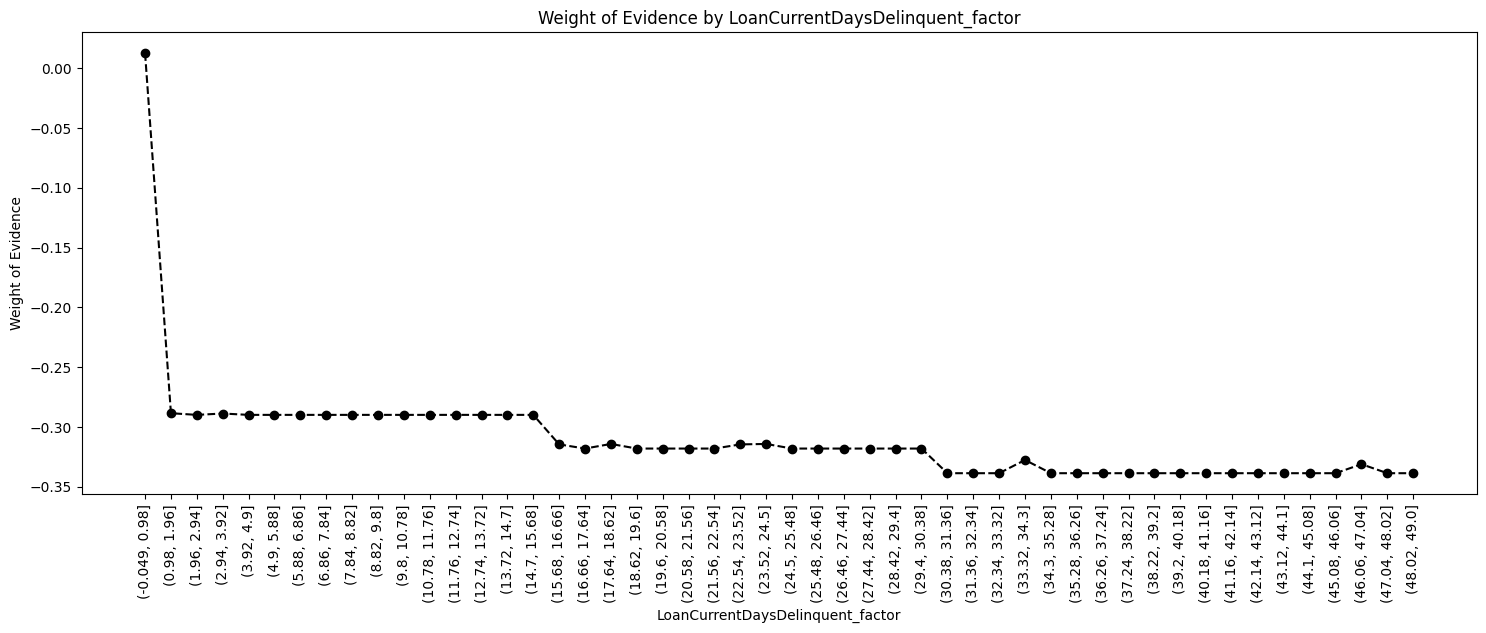

In [58]:
plot_by_woe(temp, 90)

In [59]:
def convert(x):
    if x == 0:
        return "=0"
    elif x < 50:
        return "<50"
    else:
        return "50<"

In [60]:
df_new['LoanCurrentDaysDelinquent_factor'] = df_new['LoanCurrentDaysDelinquent'].map(lambda x : convert(x))
df_new['LoanCurrentDaysDelinquent_factor'].value_counts()

LoanCurrentDaysDelinquent_factor
=0     94853
50<    17764
<50     1312
Name: count, dtype: int64

#### **MonthlyLoanPayment**

In [61]:
df_new['MonthlyLoanPayment_factor'] = pd.cut(df['MonthlyLoanPayment'], 50)

temp = woe_continuous(df_new, 'MonthlyLoanPayment_factor', target)

temp

,MonthlyLoanPayment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2.252, 45.03]",4451,2.090317,0.039068,9304.0,-4853.0,0.031584,0.026865,0.161853,NaN,NaN,0.002096
1,"(45.03, 90.06]",10615,2.310787,0.093172,24529.0,-13914.0,0.083269,0.077024,0.077966,0.220470,8.388678e-02,0.002096
2,"(90.06, 135.091]",14395,2.467315,0.126351,35517.0,-21122.0,0.120570,0.116925,0.030702,0.156528,4.726426e-02,0.002096
3,"(135.091, 180.121]",19808,2.609552,0.173863,51690.0,-31882.0,0.175473,0.176489,-0.005772,0.142237,3.647355e-02,0.002096
4,"(180.121, 225.151]",8961,2.470483,0.078654,22138.0,-13177.0,0.075152,0.072944,0.029828,0.139068,3.559995e-02,0.002096
5,"(225.151, 270.181]",8608,2.632551,0.075556,22661.0,-14053.0,0.076928,0.077793,-0.011185,0.162068,4.101321e-02,0.002096
6,"(270.181, 315.211]",7761,2.647468,0.068121,20547.0,-12786.0,0.069751,0.070779,-0.014630,0.014917,3.445367e-03,0.002096
7,"(315.211, 360.242]",8939,2.673118,0.078461,23895.0,-14956.0,0.081117,0.082792,-0.020438,0.025650,5.807448e-03,0.002096
8,"(360.242, 405.272]",7805,2.823831,0.068508,22040.0,-14235.0,0.074820,0.078801,-0.051839,0.150713,3.140141e-02,0.002096
9,"(405.272, 450.302]",3948,2.752533,0.034653,10867.0,-6919.0,0.036890,0.038301,-0.037535,0.071298,1.430416e-02,0.002096


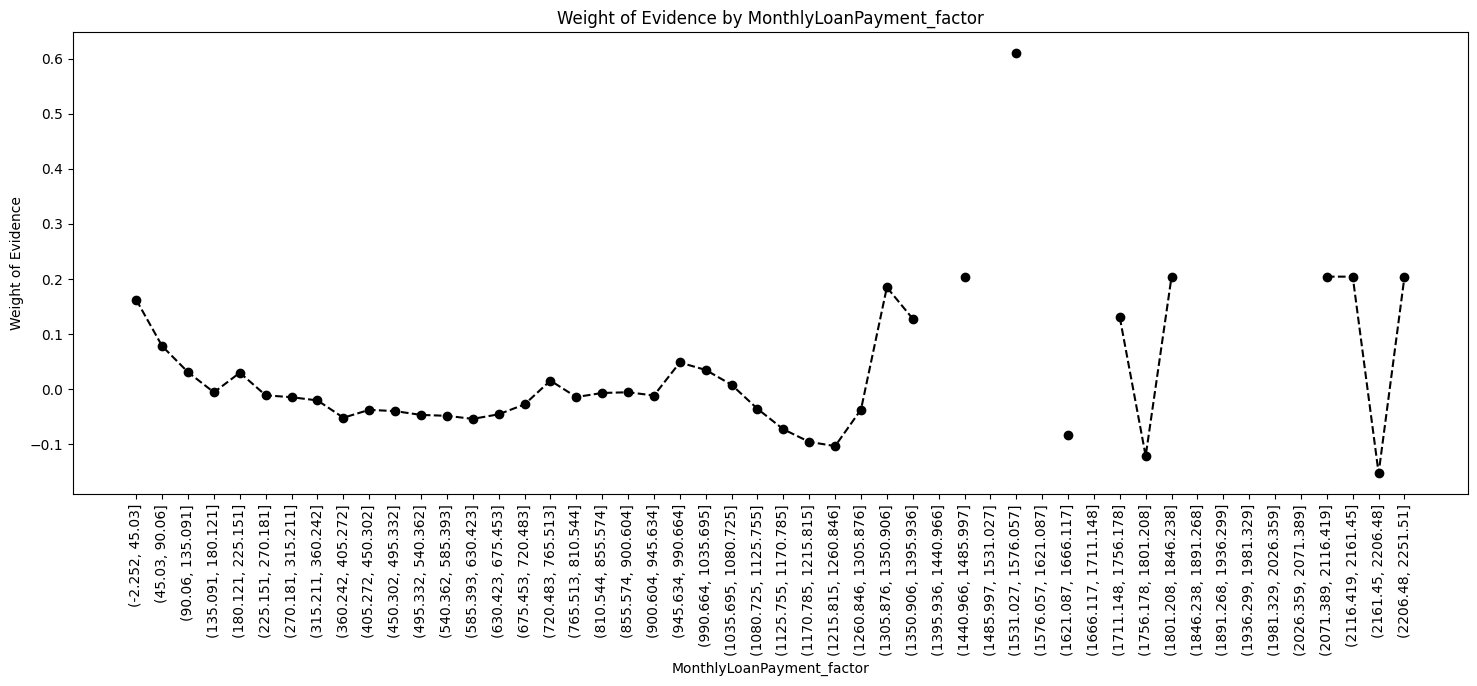

In [62]:
plot_by_woe(temp, 90)

In [63]:
temp = df[df['MonthlyLoanPayment'] > 90]

temp['MonthlyLoanPayment_factor'] = pd.cut(temp['MonthlyLoanPayment'], 50)

temp = woe_continuous(temp, 'MonthlyLoanPayment_factor', target)

temp

,MonthlyLoanPayment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(87.848, 133.24]",13846,2.465261,0.140028,34134.0,-20288.0,0.130888,0.125307,0.043582,NaN,NaN,0.000833
1,"(133.24, 176.47]",19568,2.612071,0.197896,51113.0,-31545.0,0.195995,0.194834,0.005942,0.146810,0.037641,0.000833
2,"(176.47, 219.7]",8823,2.466961,0.089229,21766.0,-12943.0,0.083463,0.079941,0.043112,0.145109,0.037170,0.000833
3,"(219.7, 262.93]",8163,2.601740,0.082555,21238.0,-13075.0,0.081438,0.080756,0.008408,0.134778,0.034704,0.000833
4,"(262.93, 306.16]",7674,2.674225,0.077609,20522.0,-12848.0,0.078693,0.079354,-0.008373,0.072485,0.016781,0.000833
5,"(306.16, 349.39]",8351,2.624476,0.084456,21917.0,-13566.0,0.084042,0.083789,0.003014,0.049749,0.011387,0.000833
6,"(349.39, 392.62]",7921,2.826411,0.080107,22388.0,-14467.0,0.085848,0.089354,-0.040027,0.201935,0.043041,0.000833
7,"(392.62, 435.85]",4682,2.784280,0.047350,13036.0,-8354.0,0.049987,0.051598,-0.031708,0.042131,0.008319,0.000833
8,"(435.85, 479.08]",3448,2.743329,0.034871,9459.0,-6011.0,0.036271,0.037126,-0.023306,0.040951,0.008401,0.000833
9,"(479.08, 522.31]",3890,2.771979,0.039341,10783.0,-6893.0,0.041348,0.042574,-0.029217,0.028650,0.005911,0.000833


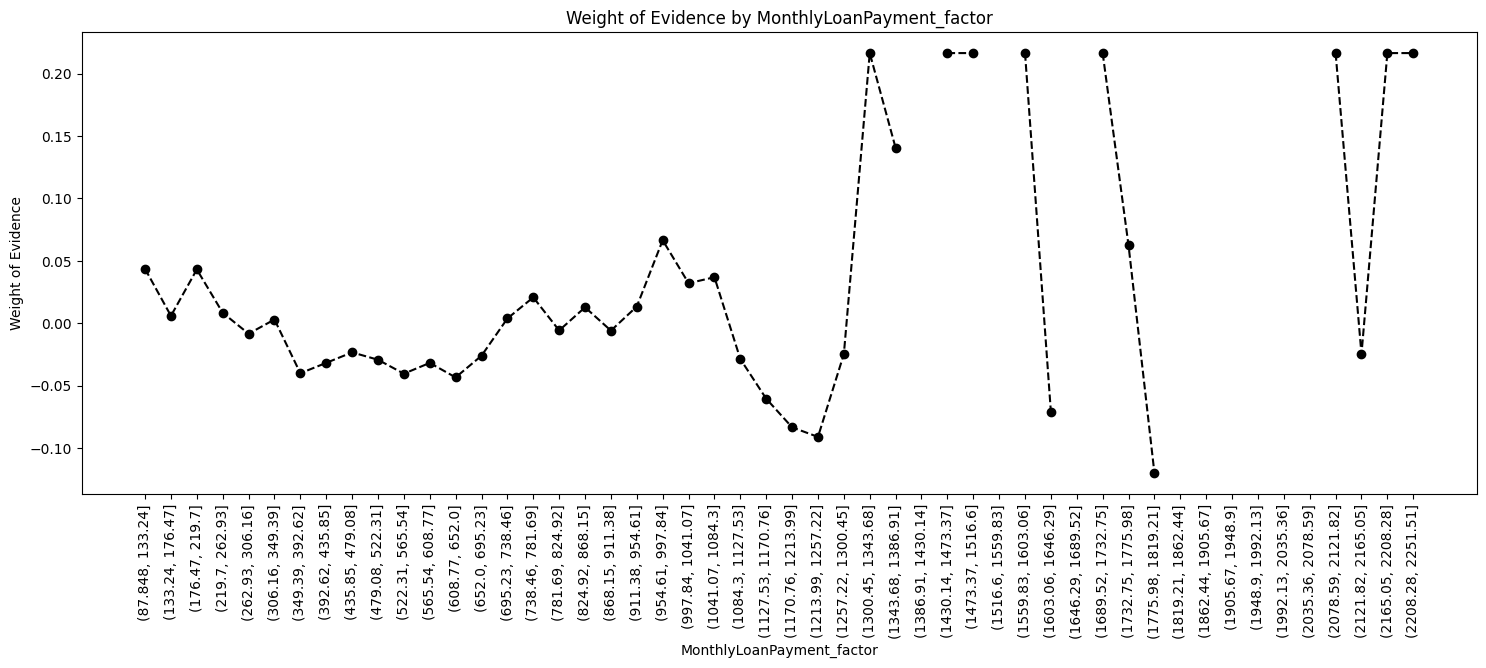

In [64]:
plot_by_woe(temp, 90)

In [65]:
def convert(x):
    if x <= 90:
        return "<90"
    elif x <= 225:
        return "90_225"
    elif x <= 360:
        return "225_360"
    elif x <= 600:
        return "360_600"
    elif x <= 750:
        return "600_750"
    else:
        return "750<"

In [66]:
df_new['MonthlyLoanPayment_factor'] = df['MonthlyLoanPayment'].map(lambda x : convert(x))
df_new['MonthlyLoanPayment_factor'].value_counts()

MonthlyLoanPayment_factor
90_225     43155
225_360    25286
360_600    23298
<90        15049
600_750     3909
750<        3232
Name: count, dtype: int64

## Analysis of Categorical Attributes

In [67]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we combine all of the operations above in a function.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [68]:
df_new = df_new[['LP_CustomerPrincipalPayments_factor', 'ProsperRating_factor',
       'LoanOriginalAmount_factor', 'LoanCurrentDaysDelinquent_factor',
       'MonthlyLoanPayment_factor']]
df_new.columns

Index(['LP_CustomerPrincipalPayments_factor', 'ProsperRating_factor',
       'LoanOriginalAmount_factor', 'LoanCurrentDaysDelinquent_factor',
       'MonthlyLoanPayment_factor'],
      dtype='object')

#### **LP_CustomerPrincipalPayments_factor**

In [69]:
temp = woe_discrete(df_new, 'LP_CustomerPrincipalPayments_factor', target)
temp.sort_values(by = 'LP_CustomerPrincipalPayments_factor', inplace=True)
temp

,LP_CustomerPrincipalPayments_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
2,1k_2k,19631,2.678671,0.172309,52585.0,-32954.0,0.178511,0.182423,-0.021676,0.167983,0.034550,0.004151
1,200_1k,29013,2.846655,0.254659,82590.0,-53577.0,0.280370,0.296586,-0.056226,0.044144,0.008235,0.004151
3,2k_10.5k,44584,2.347187,0.391331,104647.0,-60063.0,0.355247,0.332490,0.066204,0.331484,0.087881,0.004151
0,<200,14249,2.890799,0.125069,41191.0,-26942.0,0.139832,0.149143,-0.064461,NaN,NaN,0.004151
4,>10.5k,6452,2.101984,0.056632,13562.0,-7110.0,0.046039,0.039359,0.156775,0.245203,0.090571,0.004151


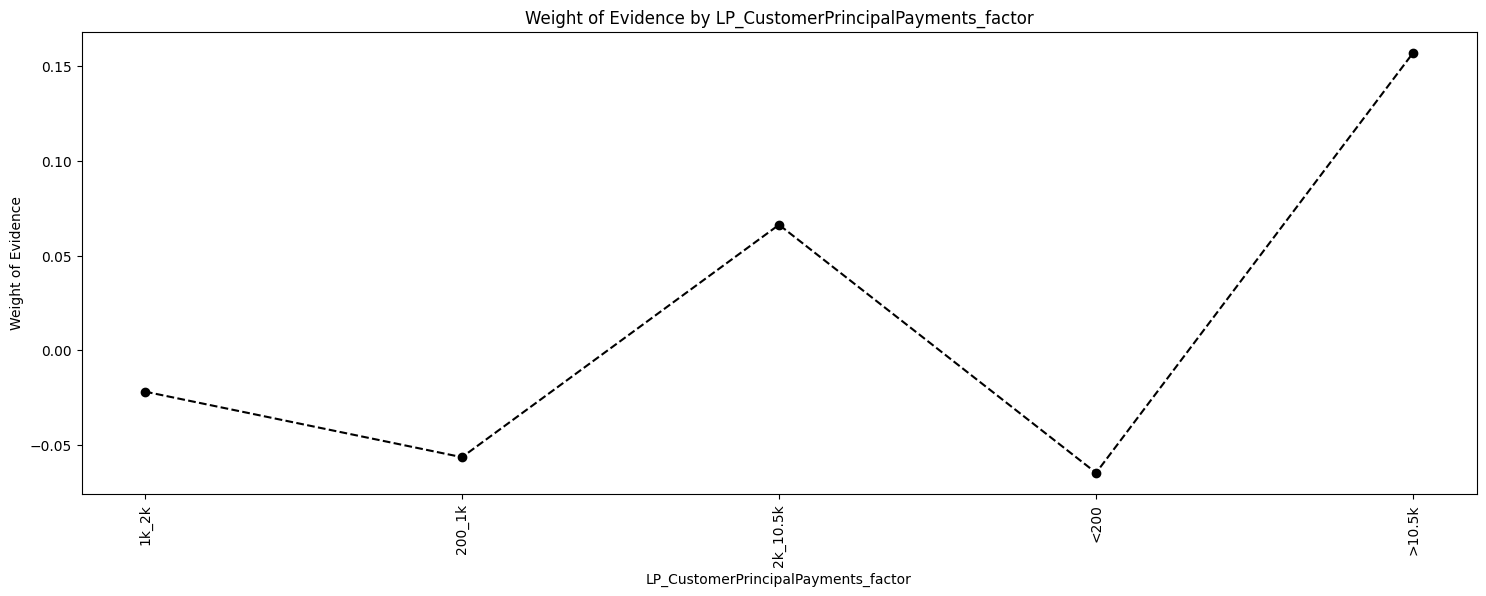

In [70]:
plot_by_woe(temp, 90)

#### **ProsperRating_factor**

In [71]:
temp = woe_discrete(df_new, 'ProsperRating_factor', target)
temp.sort_values(by = 'ProsperRating_factor', inplace=True)
temp

,ProsperRating_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
1,0,14551,2.793691,0.127720,40651.0,-26100.0,0.137999,0.144481,-0.045906,0.055548,0.010810,0.002231
3,1,5372,2.691363,0.047152,14458.0,-9086.0,0.049081,0.050297,-0.024481,0.026350,0.005716,0.002231
0,2,15581,2.849239,0.136761,44394.0,-28813.0,0.150705,0.159500,-0.056717,NaN,NaN,0.002231
6,3,47421,2.373084,0.416233,112534.0,-65113.0,0.382022,0.360445,0.058137,0.176592,0.049211,0.002231
4,4,14274,2.678717,0.125289,38236.0,-23962.0,0.129801,0.132646,-0.021686,0.012646,0.002795,0.002231
2,5,9795,2.717713,0.085975,26620.0,-16825.0,0.090367,0.093138,-0.030197,0.075978,0.015709,0.002231
5,6,6935,2.549676,0.060871,17682.0,-10747.0,0.060025,0.059492,0.008926,0.129041,0.030612,0.002231


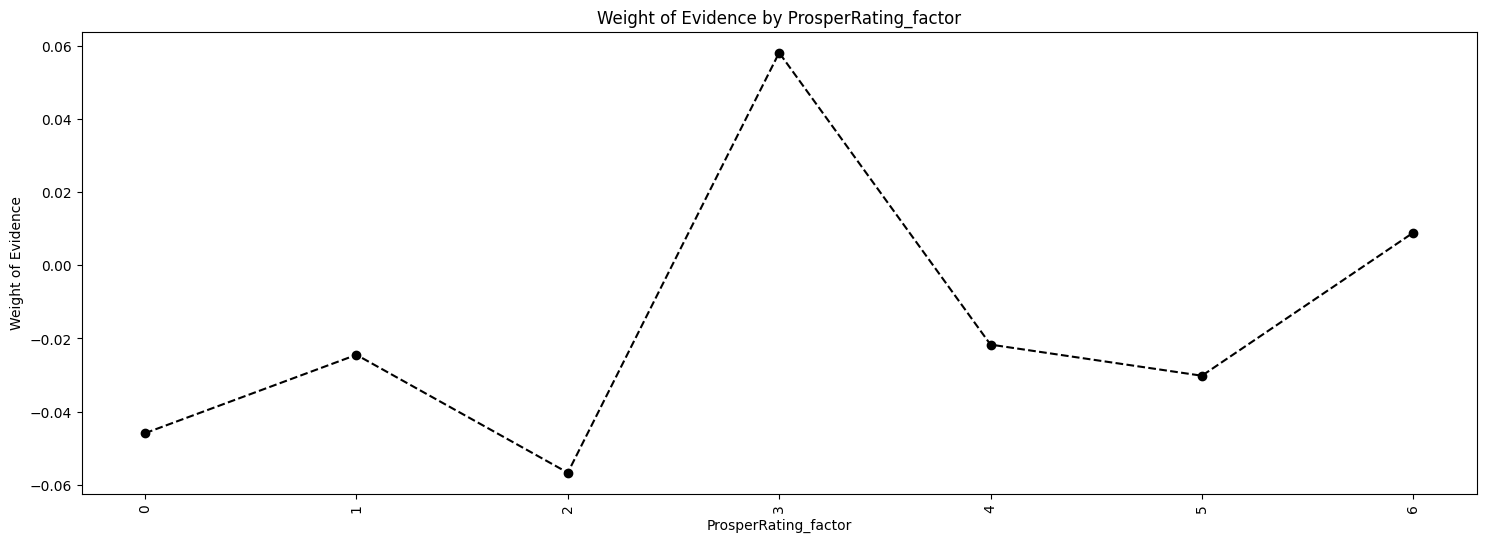

In [72]:
plot_by_woe(temp, 90)

#### **LoanOriginalAmount_factor**

In [73]:
temp = woe_discrete(df_new, 'LoanOriginalAmount_factor', target)
temp.sort_values(by = 'LoanOriginalAmount_factor', inplace=True)
temp

,LoanOriginalAmount_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
1,14.5k_19.5k,14841,2.832289,0.130265,42034.0,-27193.0,0.142694,0.150532,-0.053475,0.179476,0.032005,0.003244
2,19.5k_24.5k,7937,2.803578,0.069666,22252.0,-14315.0,0.075539,0.079243,-0.047870,0.028711,0.005605,0.003244
0,25.5k<,680,3.011765,0.005969,2048.0,-1368.0,0.006952,0.007573,-0.085480,NaN,NaN,0.003244
9,2k_3k,11022,2.334876,0.096744,25735.0,-14713.0,0.087363,0.081447,0.070126,0.012402,0.003950,0.003244
4,3.5k_4K,15105,2.739159,0.132583,41375.0,-26270.0,0.140457,0.145423,-0.034745,0.041468,0.008538,0.003244
8,3k_3.5k,3729,2.347278,0.032731,8753.0,-5024.0,0.029714,0.027811,0.066176,0.022589,0.007050,0.003244
7,4k_5k,9425,2.369867,0.082727,22336.0,-12911.0,0.075824,0.071471,0.059126,0.080160,0.023603,0.003244
6,5k_7.5k,12957,2.450027,0.113729,31745.0,-18788.0,0.107765,0.104005,0.035523,0.198549,0.050407,0.003244
5,7.5k_9.5k,6670,2.648576,0.058545,17666.0,-10996.0,0.059971,0.060870,-0.014884,0.090584,0.019861,0.003244
3,9.5k_14.5k,19027,2.780628,0.167008,52907.0,-33880.0,0.179605,0.187549,-0.043284,0.022951,0.004587,0.003244


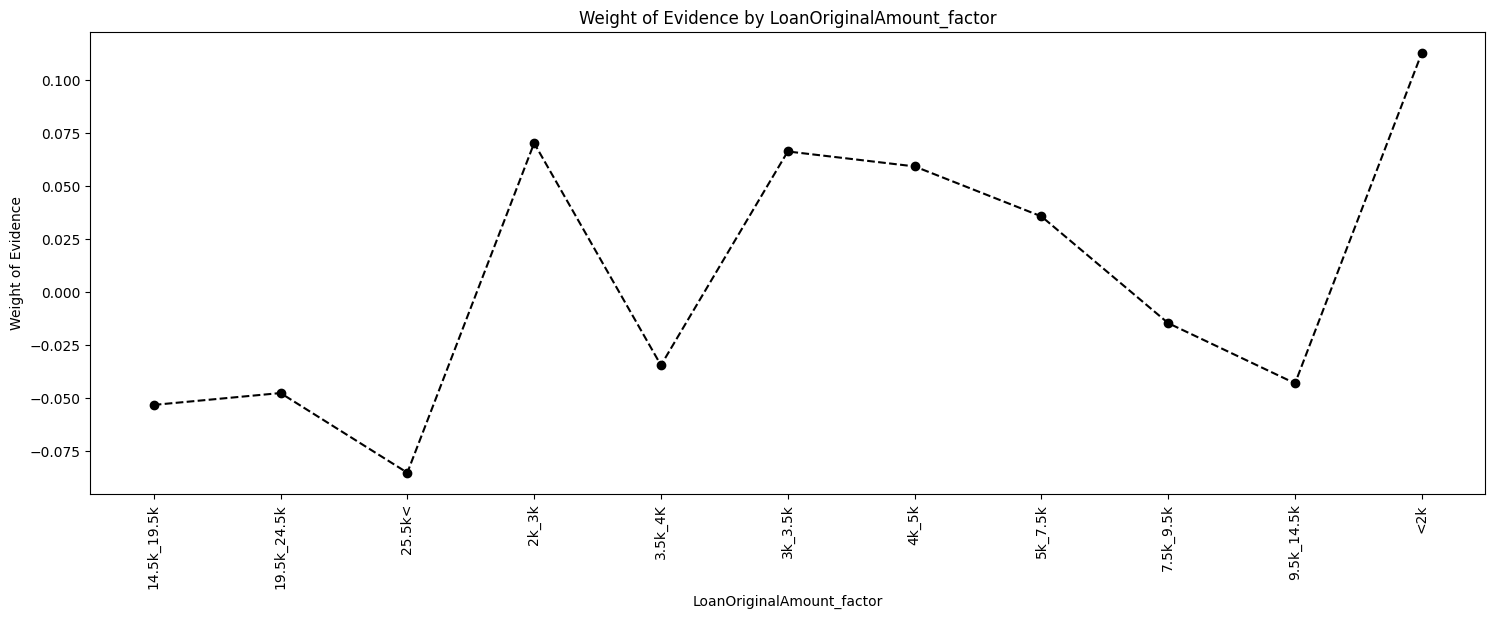

In [74]:
plot_by_woe(temp, 90)

#### **LoanCurrentDaysDelinquent_factor**

In [75]:
temp = woe_discrete(df_new, 'LoanCurrentDaysDelinquent_factor', target)
temp.sort_values(by = 'LoanCurrentDaysDelinquent_factor', inplace=True)
temp

,LoanCurrentDaysDelinquent_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
2,50<,17764,2.201137,0.155922,39101.0,-21337.0,0.132737,0.118115,0.116711,0.401701,0.120879,0.005316
0,<50,1312,6.544970,0.011516,8587.0,-7275.0,0.029150,0.040272,-0.323189,NaN,NaN,0.005316
1,=0,94853,2.602838,0.832562,246887.0,-152034.0,0.838113,0.841613,-0.004168,3.942131,0.319021,0.005316


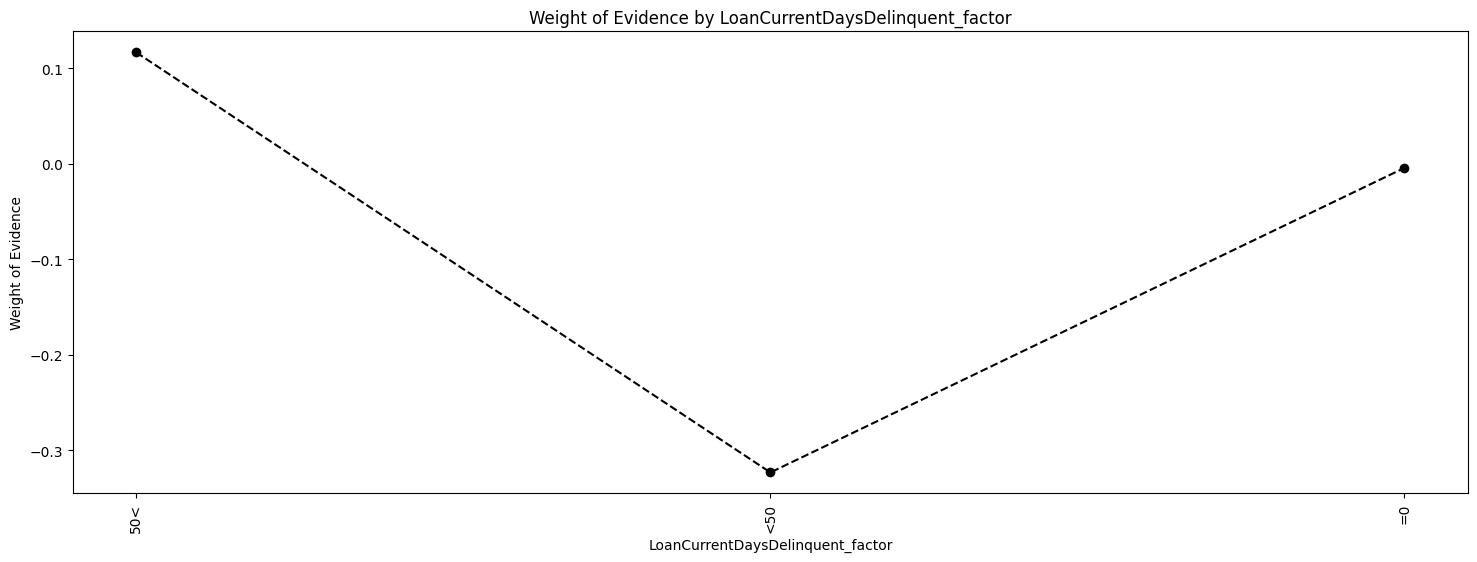

In [76]:
plot_by_woe(temp, 90)

#### **MonthlyLoanPayment_factor**

In [77]:
temp = woe_discrete(df_new, 'MonthlyLoanPayment_factor', target)
temp.sort_values(by = 'MonthlyLoanPayment_factor', inplace=True)
temp

,MonthlyLoanPayment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
2,225_360,25286,2.650676,0.221945,67025.0,-41739.0,0.227531,0.231054,-0.015365,0.122411,0.026391,0.001768
0,360_600,23298,2.794660,0.204496,65110.0,-41812.0,0.221030,0.231458,-0.046100,NaN,NaN,0.001768
1,600_750,3909,2.773088,0.034311,10840.0,-6931.0,0.036799,0.038368,-0.041755,0.021573,0.004344,0.001768
3,750<,3232,2.625000,0.028369,8484.0,-5252.0,0.028801,0.029073,-0.009421,0.025676,0.005943,0.001768
4,90_225,43155,2.533380,0.378789,109328.0,-66173.0,0.371138,0.366313,0.013086,0.091620,0.022507,0.001768
5,<90,15049,2.245199,0.132091,33788.0,-18739.0,0.114701,0.103733,0.100504,0.288181,0.087419,0.001768


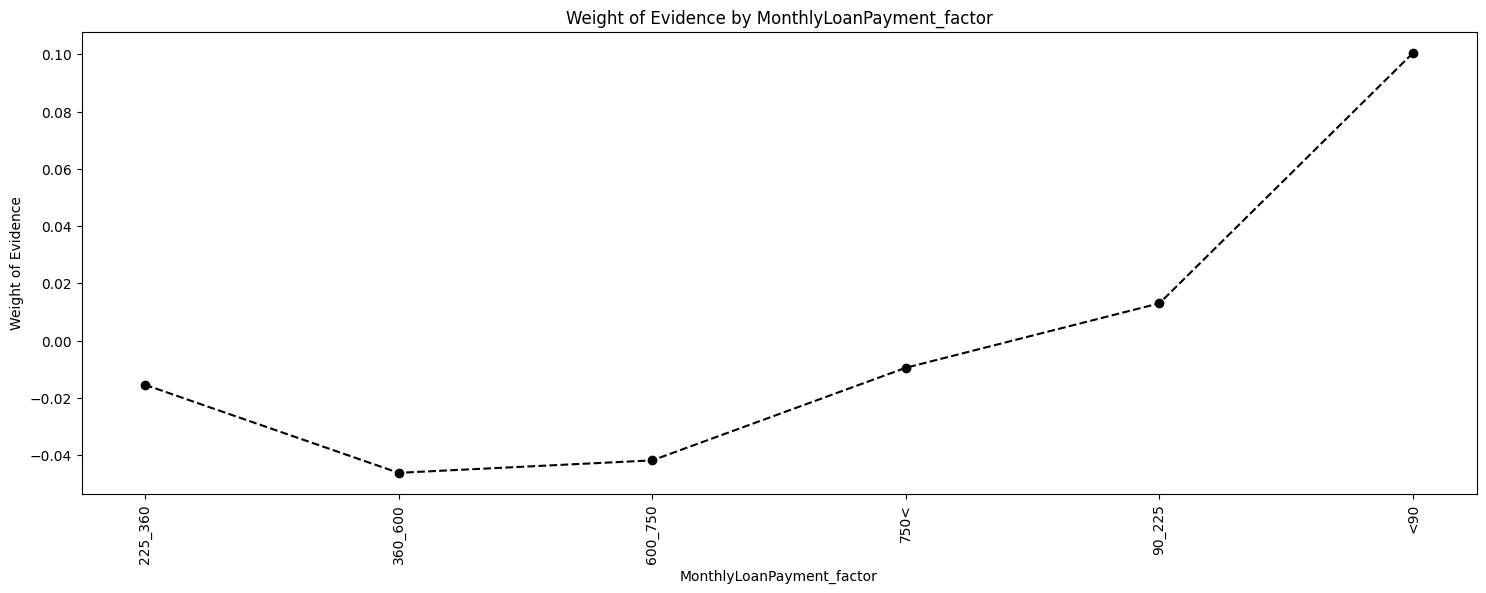

In [78]:
plot_by_woe(temp, 90)

### Algorithm (PreferredROI)

In [79]:
def PROI(df):
    # Calculate ROI
    df['InterestAmount'] = df['LoanOriginalAmount'] * df['BorrowerRate']
    df['TotalAmount'] = df['InterestAmount'] + df['LoanOriginalAmount']
    df['ROI'] = df['InterestAmount'] / df['TotalAmount']
    
    print("ROI Description:")
    print(df['ROI'].describe())

    # Setting initial PROI to median ROI
    df['PROI'] = df['ROI'].median()

    # Adjust PROI based on conditions
    df.loc[df['LP_CustomerPrincipalPayments'] <= 1000, 'PROI'] += 0.05
    df.loc[(df['LP_CustomerPrincipalPayments'] > 2000) & (df['LP_CustomerPrincipalPayments'] <= 10500), 'PROI'] -= 0.05
    df.loc[df['LP_CustomerPrincipalPayments'] > 10500, 'PROI'] -= 0.1

    df.loc[df['ProsperRating (Alpha)'].isin([2, 3]), 'PROI'] += 0.05
    df.loc[df['ProsperRating (Alpha)'] == 6, 'PROI'] -= 0.05

    df.loc[df['LoanOriginalAmount'] <= 2000, 'PROI'] -= 0.05
    df.loc[(df['LoanOriginalAmount'] > 19500) & (df['LoanOriginalAmount'] <= 25500), 'PROI'] += 0.05
    df.loc[df['LoanOriginalAmount'] > 25500, 'PROI'] += 0.1

    df.loc[df['LoanCurrentDaysDelinquent'] >= 50, 'PROI'] += 0.05

    df.loc[df['MonthlyLoanPayment'] <= 90, 'PROI'] -= 0.05
    df.loc[(df['MonthlyLoanPayment'] > 360) & (df['MonthlyLoanPayment'] <= 750), 'PROI'] += 0.05

    print("Adjusted ROI Description:")
    print(df['PROI'].describe())

    return df['PROI']

In [80]:
df['PROI'] = PROI(df)

ROI Description:
count    113929.000000
mean          0.158354
std           0.052189
min           0.000100
25%           0.118166
50%           0.155405
75%           0.200000
max           0.332220
Name: ROI, dtype: float64
Adjusted ROI Description:
count    113929.000000
mean          0.187108
std           0.070981
min          -0.044595
25%           0.155405
50%           0.205405
75%           0.255405
max           0.405405
Name: PROI, dtype: float64


## **Model Bulding**

#### Selcting feature

In [81]:
features = df.drop(columns=['ELA', 'EMI', 'PROI'])
target = df[['ELA', 'EMI', 'PROI']]

#### Importing sklearn libraries

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score


#### Tran and test the features

In [83]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


#### Applying models 

In [88]:
# Define the models
model = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge())
}
    
# Train, predict and evaluate each model
for model_name, model in model.items():
    model.fit(x_train, y_train)  # Train the model

# Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

# Calculate metrics for training set
    model_train_mse = mean_squared_error(y_train, y_train_pred, multioutput='uniform_average')
    model_train_r2 = r2_score(y_train, y_train_pred, multioutput='uniform_average')

# Calculate metrics for testing set
    model_test_mse = mean_squared_error(y_test, y_test_pred, multioutput='uniform_average')
    model_test_r2 = r2_score(y_test, y_test_pred, multioutput='uniform_average')

    print(f"Model: {model_name}")
    print("Model performance for training set")
    print(f"- Mean Squared Error: {model_train_mse:.4f}")
    print(f"- R² Score: {model_train_r2:.4f}")
    print("-----------------------------------------------")
    print("Model performance for testing set")
    print(f"- Mean Squared Error: {model_test_mse:.4f}")
    print(f"- R² Score: {model_test_r2:.4f}")
    print('='*50)
    print('\n')


Model: Linear Regression
Model performance for training set
- Mean Squared Error: 57398576.5676
- R² Score: 0.8501
-----------------------------------------------
Model performance for testing set
- Mean Squared Error: 66406843.0962
- R² Score: 0.8485


Model: Ridge Regression
Model performance for training set
- Mean Squared Error: 57567646.9807
- R² Score: 0.8475
-----------------------------------------------
Model performance for testing set
- Mean Squared Error: 66717100.6790
- R² Score: 0.8455




### Residual Analysis:

Max residual: ELA     127138.101941
EMI       2718.642755
PROI         0.159152
dtype: float64
Min residual: ELA    -420853.018272
EMI      -1489.071089
PROI        -0.180871
dtype: float64


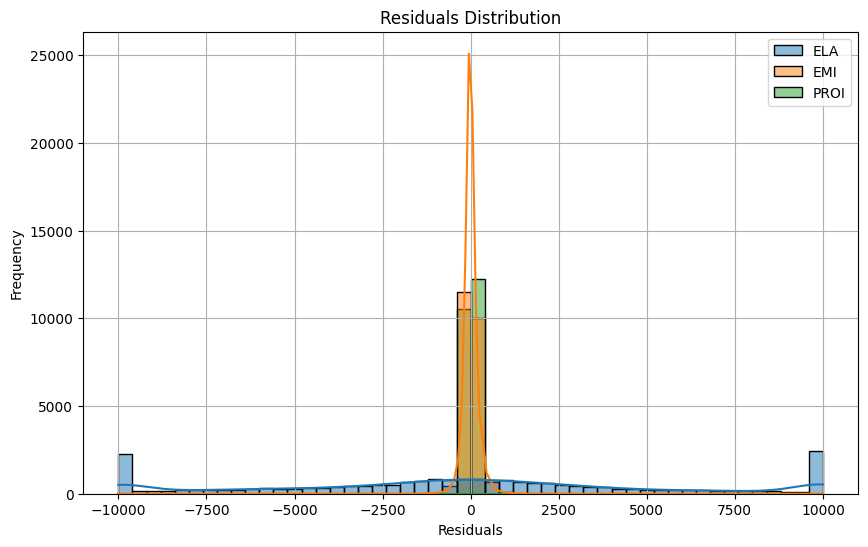

In [85]:
# y_test and y_test_pred are defined
residuals = y_test - y_test_pred
                                              
# Check for extreme outliers 

print(f"Max residual: {residuals.max()}") 
print(f"Min residual: {residuals.min()}")

# Clipping the residuals to remove extreme outliers
clipped_residuals = np.clip(residuals, -10000, 10000)
plt.figure(figsize=(10, 6))
sns.histplot(clipped_residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


###  Hyperparameter Tuning

In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = {'estimator__alpha': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(MultiOutputRegressor(Ridge()), param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'estimator__alpha': 0.1}


### Model Validation

In [87]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(MultiOutputRegressor(LinearRegression()), features, target, cv=5, scoring='r2')
print("Cross-validation R² scores: ", cv_scores)
print("Mean CV R² score: ", cv_scores.mean())


Cross-validation R² scores:  [0.85155888 0.85082248 0.84980226 0.84801792 0.8467248 ]
Mean CV R² score:  0.8493852658665786


In [89]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor


# Define your models
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge())
}

# Create a dictionary to hold the pipelines
pipelines = {}

# Create and fit pipelines for each model
for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # You can add other preprocessing steps here
        ('regressor', model)
    ])
    pipeline.fit(x_train, y_train)  # Fit the model on the training data
    pipelines[model_name] = pipeline

# Save the pipelines to a pickle file
with open('multioutput_pipelines.pkl', 'wb') as f:
    pickle.dump(pipelines, f)